# "Home Grown" Decision Tree in PySpark

This is our implementation of a Decision Tree in Spark, based on the [PLANET algorithm](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36296.pdf)

In [1]:
import csv
from itertools import count
from functools import partial
from operator import itemgetter

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

#from util import stats, TreeNode
from tree import DecisionTreeBinaryClassifier

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel, LabeledPoint, RandomForest

app_name = "w261_tree_scratch"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
class DecisionTreeBinaryClassifier:
    def __init__(self, num_features, categorical_features_info, max_bins=32, max_depth=10, min_per_node=1):
        self.num_features = num_features
        self.categorical_features_info = categorical_features_info
        self.max_bins = max_bins
        self.max_depth = max_depth
        self.min_per_node = min_per_node
    
    def train(self, dataRDD):
        node_id_counter = count()
        def seq_op(counts, row):
            label = row[0]
            counts[int(label)] += 1
            return counts
        comb_op = lambda counts1, counts2: [counts1[0] + counts2[0], counts1[1] + counts2[1]]
        label_counts = dataRDD.aggregate([0, 0], seq_op, comb_op)
        n, probability, gini = stats(label_counts)

        fraction = sample_fraction_for_accurate_splits(n, self.max_bins)
        sample = dataRDD.sample(withReplacement=False, fraction=fraction)
        continuous_bins = sample.flatMap(spread_row) \
            .groupByKey() \
            .mapValues(partial(to_bins, self.max_bins)) \
            .collectAsMap()
        treeRDD = dataRDD.map(lambda pair: (pair[0], discretize(continuous_bins, pair[1])))
        self.continuous_bins = continuous_bins
        
        tree_root = TreeNode(next(node_id_counter), n, gini, probability)
        tree_root.ranges = { i: (0, self.max_bins) for i in range(self.num_features) }
        self.tree_root = tree_root

        frontier = [tree_root]
        depth = 0
        while len(frontier) > 0:
            print(depth, frontier)
            candidate_splits = {}
            for node in frontier:
                candidate_splits[node.id] = gen_candidate_splits(node, self.num_features)

            statsRDD = treeRDD.flatMap(partial(split_statistics, tree_root, candidate_splits)) \
                .reduceByKey(result_adder) \
                .mapValues(to_gini)
            
            best_splits = statsRDD.map(shift_key) \
                .reduceByKey(get_purest_split) \
                .collectAsMap()
            
            print(best_splits)
            
            new_frontier = []
            for node in frontier:
                if node.id not in best_splits:
                    continue
                split_data = best_splits[node.id]
                (split_feat, split_val), _, (left_n, left_proba, left_gini), (right_n, right_proba, right_gini) = split_data
                if left_n < self.min_per_node or right_n < self.min_per_node:
                    continue
                parent_range = node.feat_range(split_feat)
                left = TreeNode(next(node_id_counter), left_n, left_gini, left_proba)
                left.ranges = { split_feat: (parent_range[0], split_val + 1) }
                right = TreeNode(next(node_id_counter), right_n, right_gini, right_proba)
                right.ranges = { split_feat: (split_val + 1, parent_range[1]) }
                node.split(split_feat, split_val, left, right)
                if 0 < left.probability and left.probability < 1:
                    new_frontier.append(left)
                if 0 < right.probability and right.probability < 1:
                    new_frontier.append(right)
            depth += 1
            if depth >= self.max_depth:
                frontier = []
            else:
                frontier = new_frontier
        print(tree_root)
    
    def predict(self, dataRDD):
        return dataRDD.map(partial(discretize, self.continuous_bins)) \
            .map(self.tree_root.get_probability)


def sample_fraction_for_accurate_splits(total_num_rows, max_bins):
    """
    determines how many rows to sample from the RDD in order to calculate the bins for discretizing continuous values
    uses same heuristic as Spark MLlib
    https://github.com/apache/spark/blob/ebd899b8a865395e6f1137163cb508086696879b/mllib/src/main/scala/org/apache/spark/ml/tree/impl/RandomForest.scala#L1168-L1177
    """
    required_samples = max(max_bins * max_bins, 10_000)
    if required_samples >= total_num_rows:
        return 1
    return required_samples / total_num_rows

def spread_row(row):
    return [ (i, val) for i, val in enumerate(row[1]) if val != 0 ]

def to_bins(max_bins, sample):
    return np.quantile(list(sample), np.linspace(0, 1, max_bins + 1)[1:-1])

def discretize(bins, feat_vector):
    binned_feat_vector = []
    for i, val in enumerate(feat_vector):
        binned_feat_vector.append(to_discrete(val, bins[i]))
    return binned_feat_vector

def to_discrete(continuous_val, bins):
    for i in range(0, len(bins)):
        if continuous_val < bins[i]:
            return i
    return len(bins)

def gen_candidate_splits(node, num_feats):
    candidates = {}
    for i in range(num_feats):
        feat_range = node.feat_range(i)
        if feat_range[1] - feat_range[0] > 1:
            candidates[i] = list(range(*feat_range))
    return candidates

def split_statistics(tree_root, candidate_splits, pair):
    label, feat_vector = pair
    node_assignment = tree_root.get_assigned_node_id(feat_vector)
    if node_assignment not in candidate_splits:
        return []
    candidates_to_evaluate = candidate_splits[node_assignment]

    for feat_idx, split_vals in candidates_to_evaluate.items():
        for split_val in split_vals:
            results = [[0, 0], [0, 0]]
            to_right = feat_vector[feat_idx] > split_val
            results[int(to_right)][int(label)] = 1
            yield (node_assignment, feat_idx, split_val), results

def result_adder(results1, results2):
    return [[results1[0][0] + results2[0][0], results1[0][1] + results2[0][1]],
            [results1[1][0] + results2[1][0], results1[1][1] + results2[1][1]]]

def to_gini(results):
    results1, results2 = results
    stats1 = stats(results1)
    stats2 = stats(results2)
    if stats1[2] is np.inf or stats2[2] is np.inf:
        return np.inf, stats1, stats2
    total = stats1[0] + stats2[0]
    return stats1[0] / total * stats1[2] + stats2[0] / total * stats2[2], stats1, stats2

def shift_key(pair):
    tuple_key, tuple_data = pair
    return (tuple_key[0], (tuple_key[1:],) + tuple_data)

def get_purest_split(data1, data2):
    if data1[1] < data2[1]:
        return data1
    return data2

In [8]:
n = 30000

pos = np.random.multivariate_normal((4, 0), ((1., -0.5), (-0.5, 1.)), n)
pos = np.hstack((pos, np.ones((n, 1))))
neg = np.random.multivariate_normal((5.5, 1.5), ((1., -0.5), (-0.5, 1.)), n)
neg = np.hstack((neg, np.zeros((n, 1))))

data = np.vstack((pos, neg))
np.random.shuffle(data)

toyRDD = sc.parallelize(data).map(lambda row: (row[-1], row[:-1]))

In [ ]:
tree = DecisionTreeBinaryClassifier(2, {}, max_depth=7)
%time tree.train(toyRDD)

In [14]:
probs = tree.predict(toyRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == data[:, 2])
print(accuracy)
print(confusion_matrix(data[:, 2], predictions))
print(classification_report(data[:, 2], predictions))

0.9347666666666666
[[28053  1947]
 [ 1967 28033]]
             precision    recall  f1-score   support

        0.0       0.93      0.94      0.93     30000
        1.0       0.94      0.93      0.93     30000

avg / total       0.93      0.93      0.93     60000



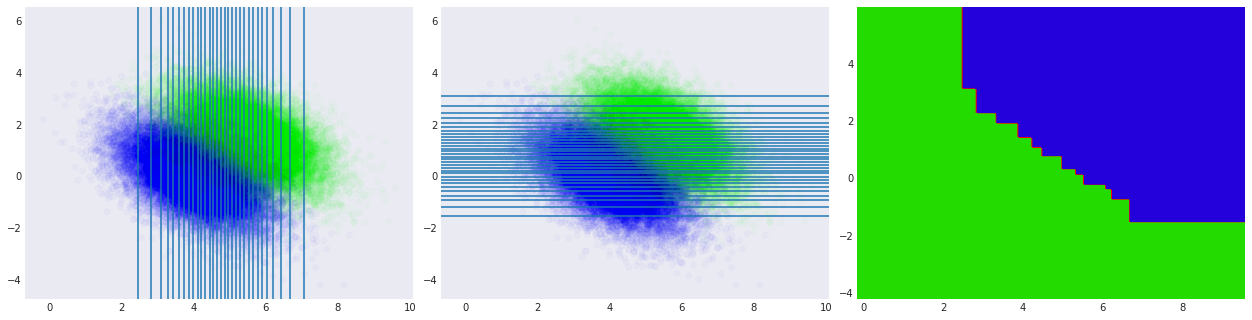

In [11]:
colors = np.array([[0., 1., 0., 0.02] if label == 0 else [0., 0., 1., 0.02] for label in data[:, 2]])

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[0]:
    plt.axvline(x=i)

plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[1]:
    plt.axhline(y=i)
    
plt.subplot(1, 3, 3)
plot_step = 0.05

x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

meshRDD = sc.parallelize(np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1))))
z = tree.predict(meshRDD).collect()
z = np.array(z).round().reshape(xx.shape)
cs = plt.contourf(xx, yy, z, cmap=plt.cm.brg)

In [16]:
from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()
cancerRDD = sc.parallelize(zip(breast_cancer_data.target, breast_cancer_data.data))

cancer_tree = DecisionTreeBinaryClassifier(breast_cancer_data.data.shape[1], {}, max_depth=7)
%time cancer_tree.train(cancerRDD)

In [42]:
probs = cancer_tree.predict(cancerRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == breast_cancer_data.target)
print(accuracy)
print(confusion_matrix(breast_cancer_data.target, predictions))
print(classification_report(breast_cancer_data.target, predictions))

0.9982425307557118
[[211   1]
 [  0 357]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       212
          1       1.00      1.00      1.00       357

avg / total       1.00      1.00      1.00       569

